# 07 - Analysis

In [3]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore", UserWarning)

import glob
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rcParams

random_seed = 12345
np.random.seed(random_seed)
sc.settings.set_figure_params(dpi=80)
sc.settings.verbosity = 3


def run_scvelo(adata):
    """Run basic workflow for computing velocities."""
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2_000)
    sc.tl.pca(adata, random_state=random_seed)
    sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=random_seed)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    scv.tl.recover_dynamics(adata, n_jobs=2)
    scv.tl.velocity(adata, mode='dynamical')
    scv.tl.velocity_graph(adata)

In [2]:
raw = sc.read("../data/processed/06_sb3_rawcounts.h5ad")

In [3]:
adata = raw[raw.obs.Stage.isin(["PECAM", "Pdgfra", "Primed"])]
adata = adata[adata.obs.Pool_barcode != "CTAC"]

In [4]:
adata.var['percent.mito'] = adata.var_names.str.startswith("mt-")
adata.var["percent.ercc"] = adata.var_names.str.startswith("ERCC-")
adata.var["percent.ribo"] = adata.var_names.str.startswith("Rp[ls]")

Trying to set attribute `.var` of view, copying.


In [5]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['percent.mito', 'percent.ercc', 'percent.ribo'], percent_top=None, log1p=False, inplace=True)

In [6]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

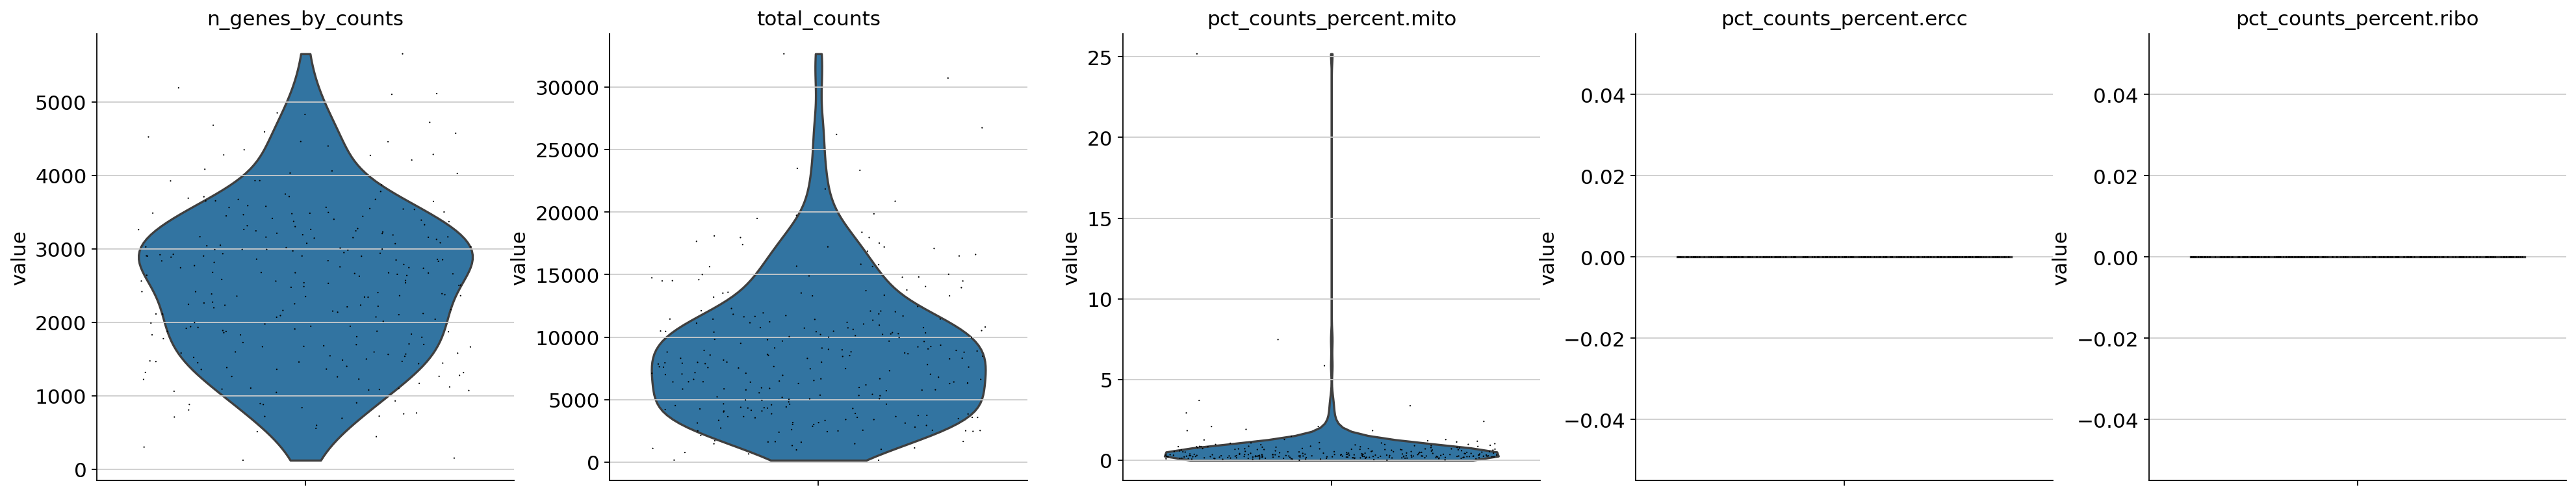

In [7]:
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_percent.mito", "pct_counts_percent.ercc", "pct_counts_percent.ribo"], jitter=0.4, multi_panel=True)

<AxesSubplot:xlabel='total_counts', ylabel='n_genes_by_counts'>

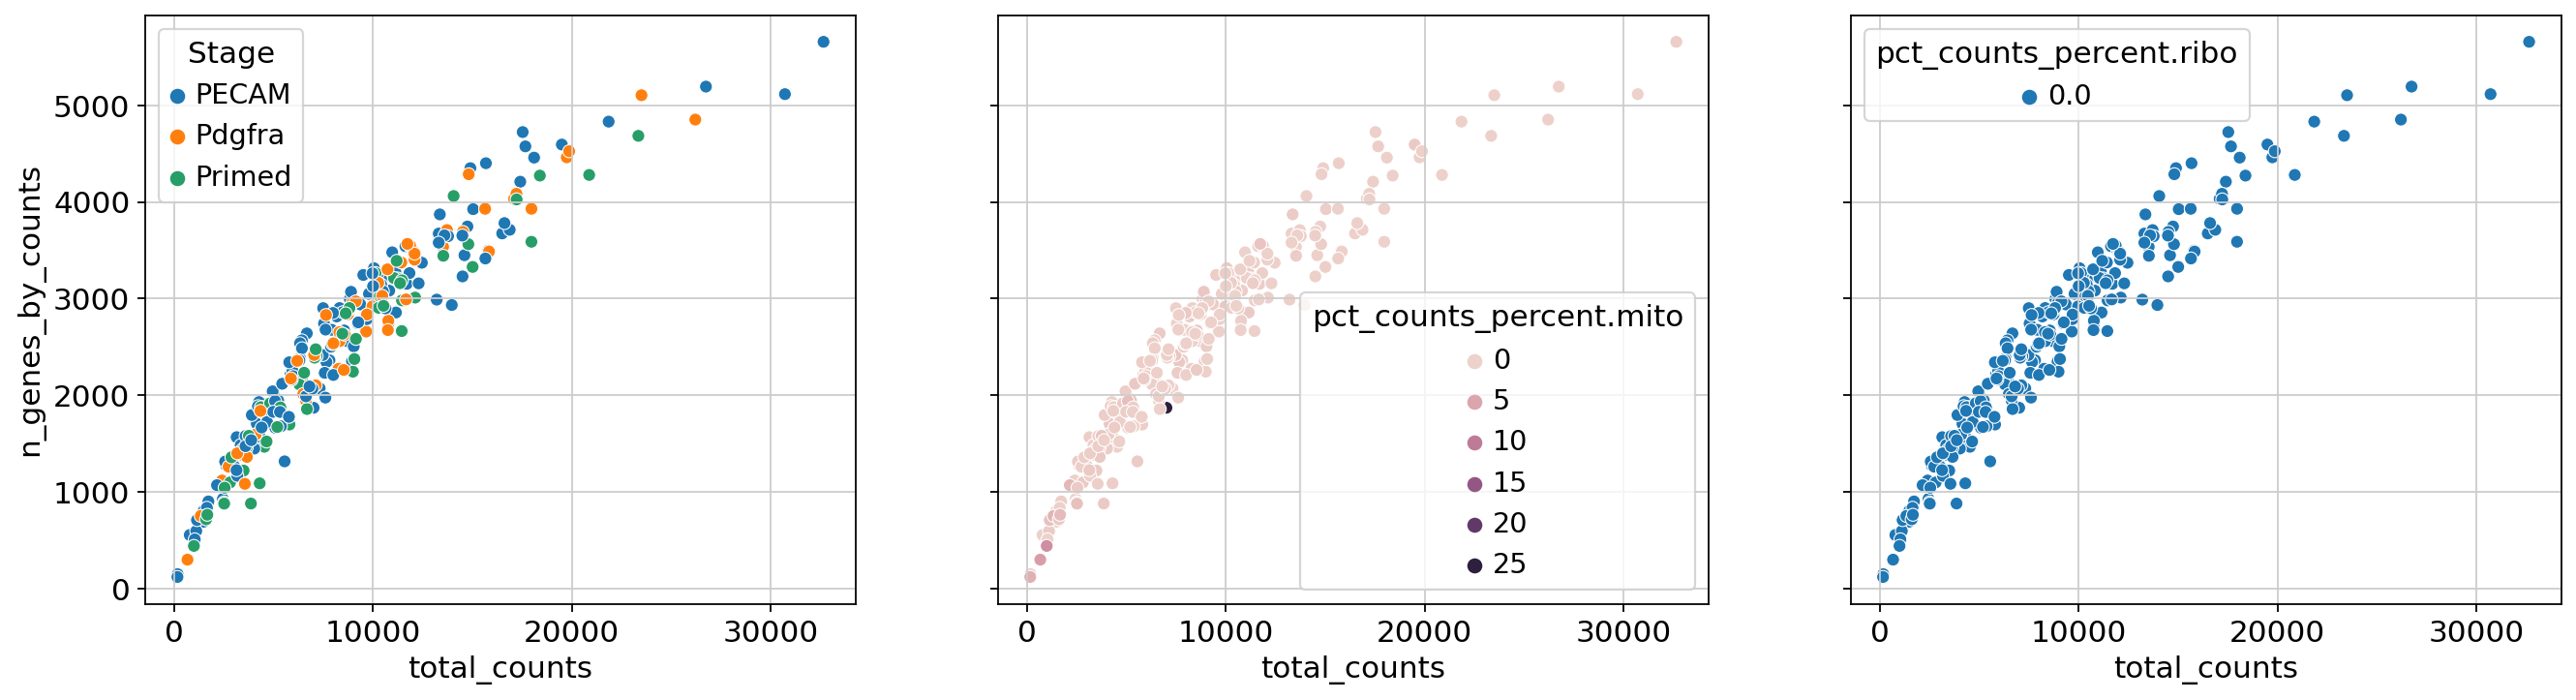

In [8]:
fig, ax = plt.subplots(1,3, figsize=(20, 5), sharey=True)
sns.scatterplot(x='total_counts', y='n_genes_by_counts', ax=ax[0], data=adata.obs, hue='Stage')
sns.scatterplot(x='total_counts', y='n_genes_by_counts', ax=ax[1], hue='pct_counts_percent.mito', data=adata.obs)
sns.scatterplot(x='total_counts', y='n_genes_by_counts', ax=ax[2], hue='pct_counts_percent.ribo', data=adata.obs)

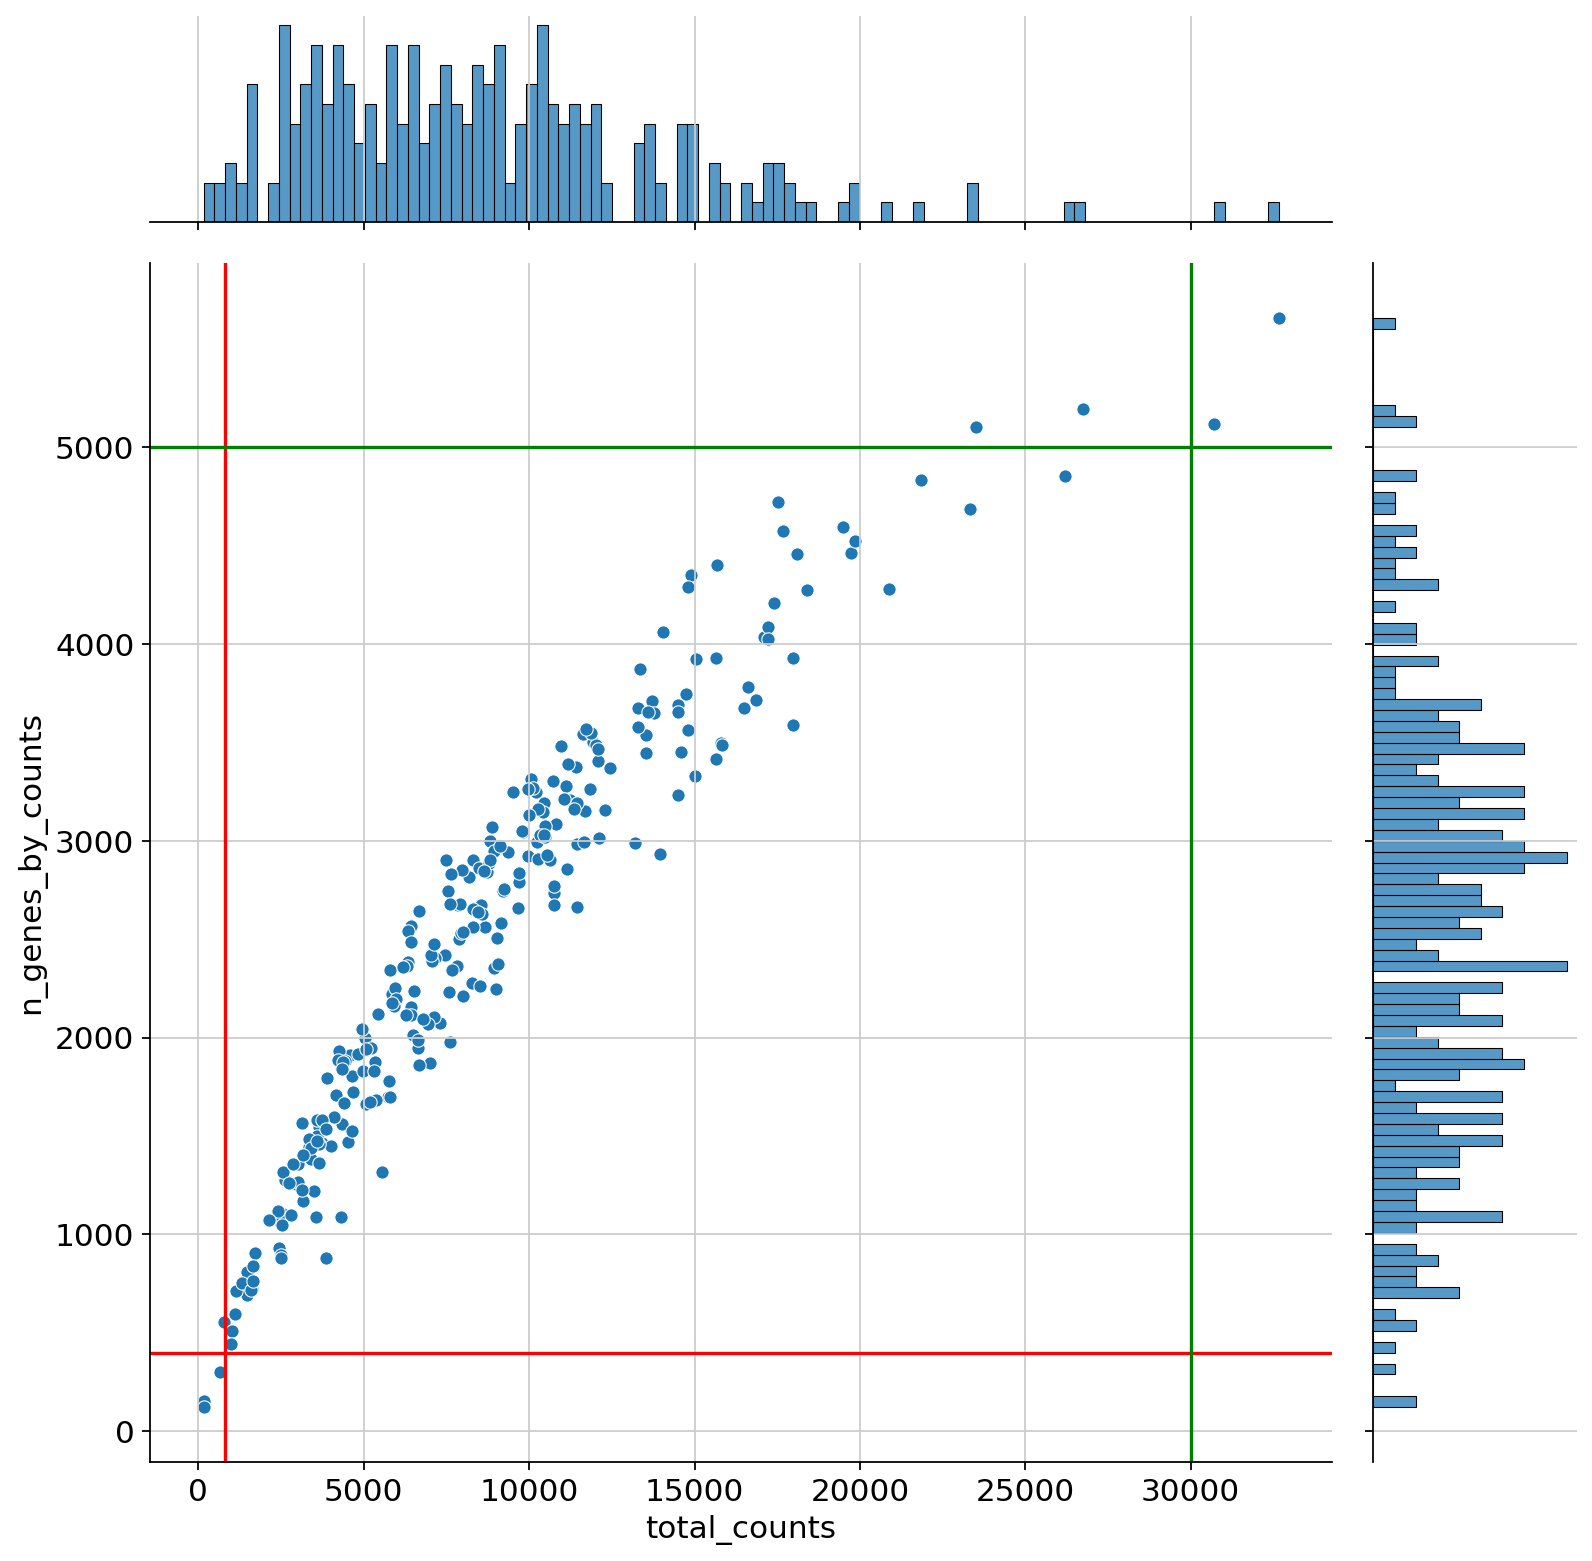

In [9]:
min_genes = 400
max_genes = 5000
min_cells = 800
max_cells = 30e3

p = sns.jointplot(x='total_counts', y='n_genes_by_counts', data=adata.obs, marginal_kws=dict(bins=100), height=10)
# min
p.ax_joint.axvline(x=min_cells, color='red')
p.ax_joint.axhline(y=min_genes, color='red')

# max
p.ax_joint.axvline(x=max_cells, color='green')
p.ax_joint.axhline(y=max_genes, color='green')

In [10]:
print(f'Before filtering: {adata.shape}')

# Remove ERCC and Rp genes
adata = adata[:, ~adata.var_names.str.startswith("ERCC-")]
adata = adata[:, ~adata.var_names.str.startswith("Rp[ls]")]

# Remove Zero stage
adata = adata[adata.obs.Stage != "Zero"]

sc.pp.filter_cells(adata, min_genes=min_genes)
sc.pp.filter_cells(adata, min_counts=min_cells)
sc.pp.filter_cells(adata, max_genes=max_genes)
sc.pp.filter_cells(adata, max_counts=max_cells)

sc.pp.filter_genes(adata, min_cells=3)
print(f'After filtering: {adata.shape}')

Before filtering: (264, 53546)
filtered out 3 cells that have less than 400 genes expressed


Trying to set attribute `.obs` of view, copying.


filtered out 1 cells that have less than 800 counts
filtered out 4 cells that have more than 5000 genes expressed
filtered out 40302 genes that are detected in less than 3 cells
After filtering: (256, 13244)


In [11]:
sc.pp.normalize_total(adata, target_sum=10_000)

normalizing counts per cell
    finished (0:00:00)


In [12]:
sc.pp.log1p(adata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


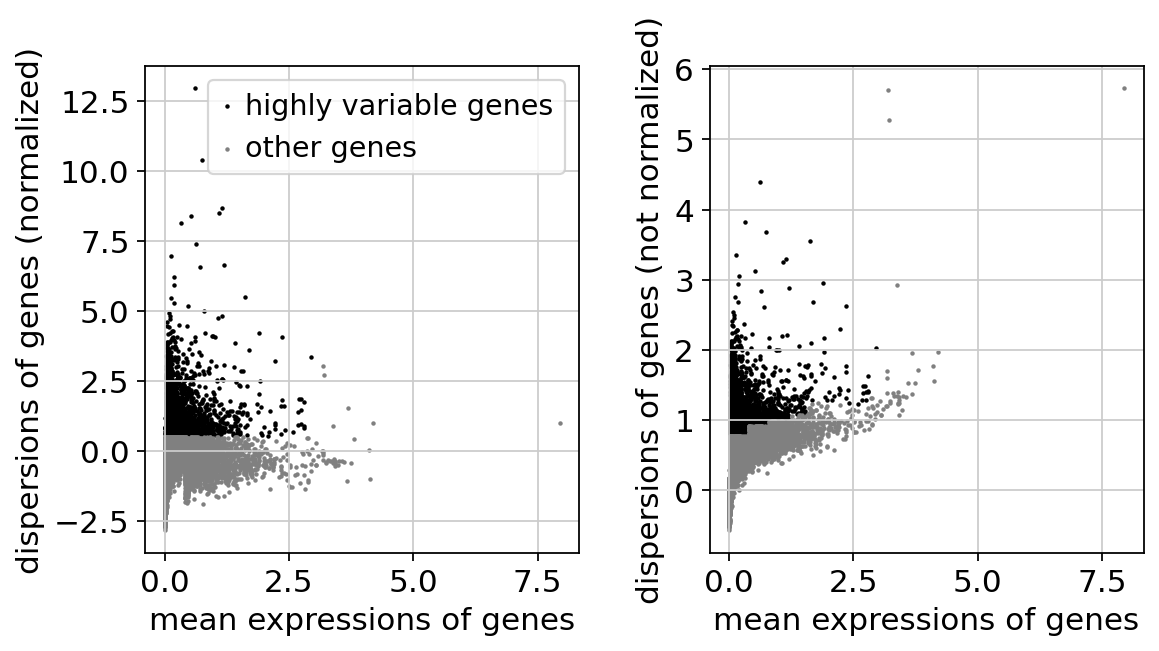

In [13]:
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

In [14]:
adata.raw = adata

In [15]:
sc.pp.scale(adata, max_value=10)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


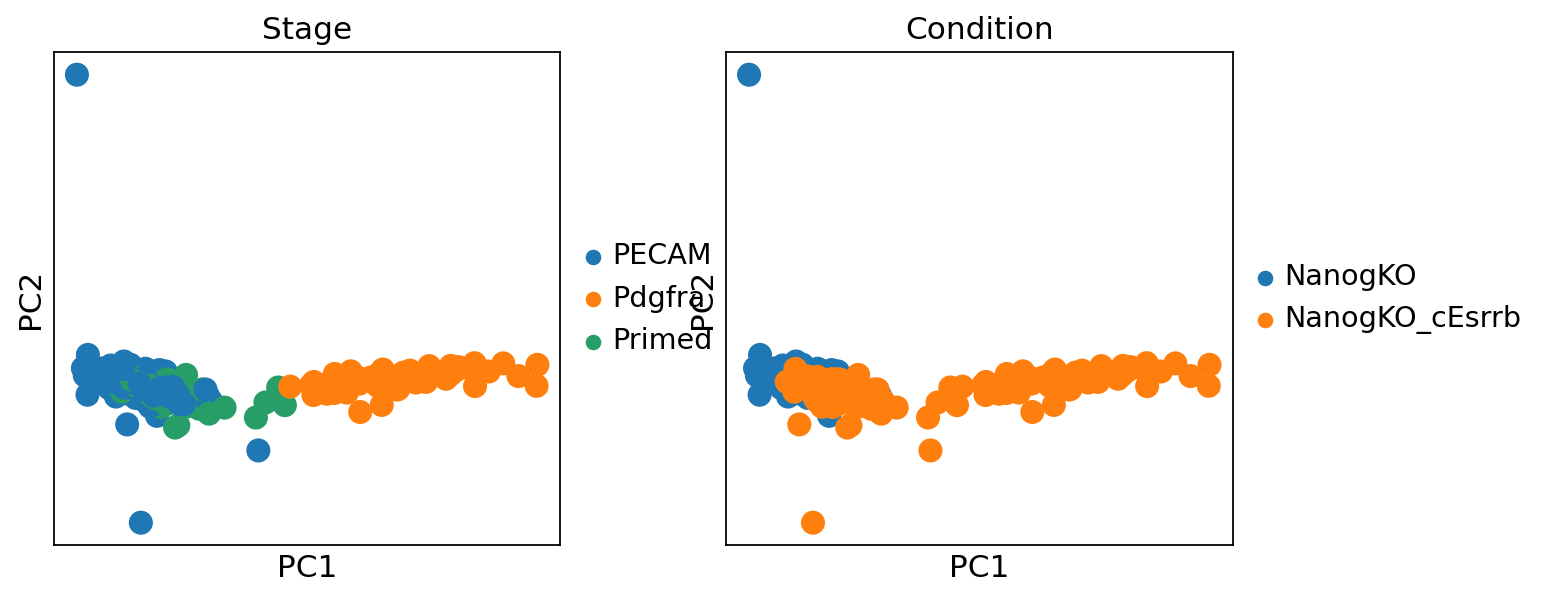

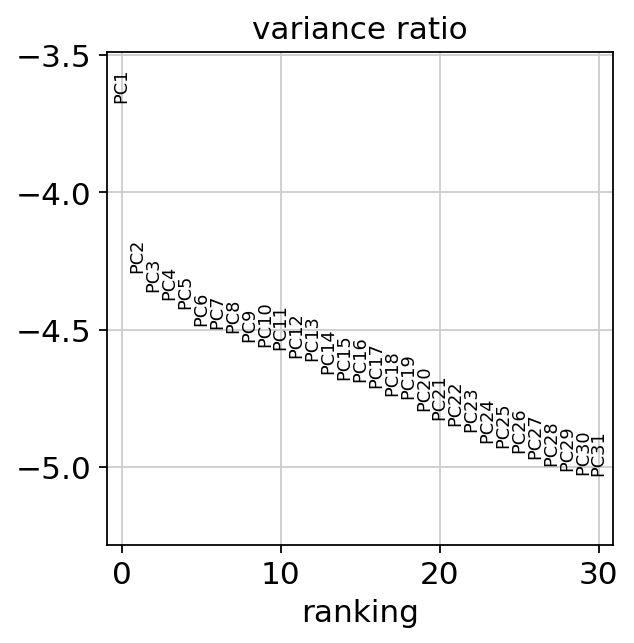

In [16]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color=['Stage', 'Condition'])
sc.pl.pca_variance_ratio(adata, log=True)

In [17]:
sc.pp.neighbors(adata, n_pcs=8, random_state=random_seed)
sc.tl.umap(adata, random_state=random_seed)
sc.tl.louvain(adata, random_state=random_seed, resolution = 0.3) # resolution = 0.3 gives 3 clusters similar to seurat
sc.tl.leiden(adata, random_state=random_seed)

computing neighbors
    using 'X_pca' with n_pcs = 8
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 3 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [18]:
adata

AnnData object with n_obs × n_vars = 256 × 13244
    obs: 'Well_ID', 'Well_coordinates', 'plate_ID', 'Subject_ID', 'Amp_batch_ID', 'Cell_barcode', 'Pool_barcode', 'Batch', 'Condition', 'SampleName', 'Stage', 'Stage_FACS', 'Source', 'SubGroup', 'Group', 'Clone', 'UFD', 'FACS_index', 'n_genes_by_counts', 'total_counts', 'total_counts_percent.mito', 'pct_counts_percent.mito', 'total_counts_percent.ercc', 'pct_counts_percent.ercc', 'total_counts_percent.ribo', 'pct_counts_percent.ribo', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'n_counts', 'louvain', 'leiden'
    var: 'percent.mito', 'percent.ercc', 'percent.ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 

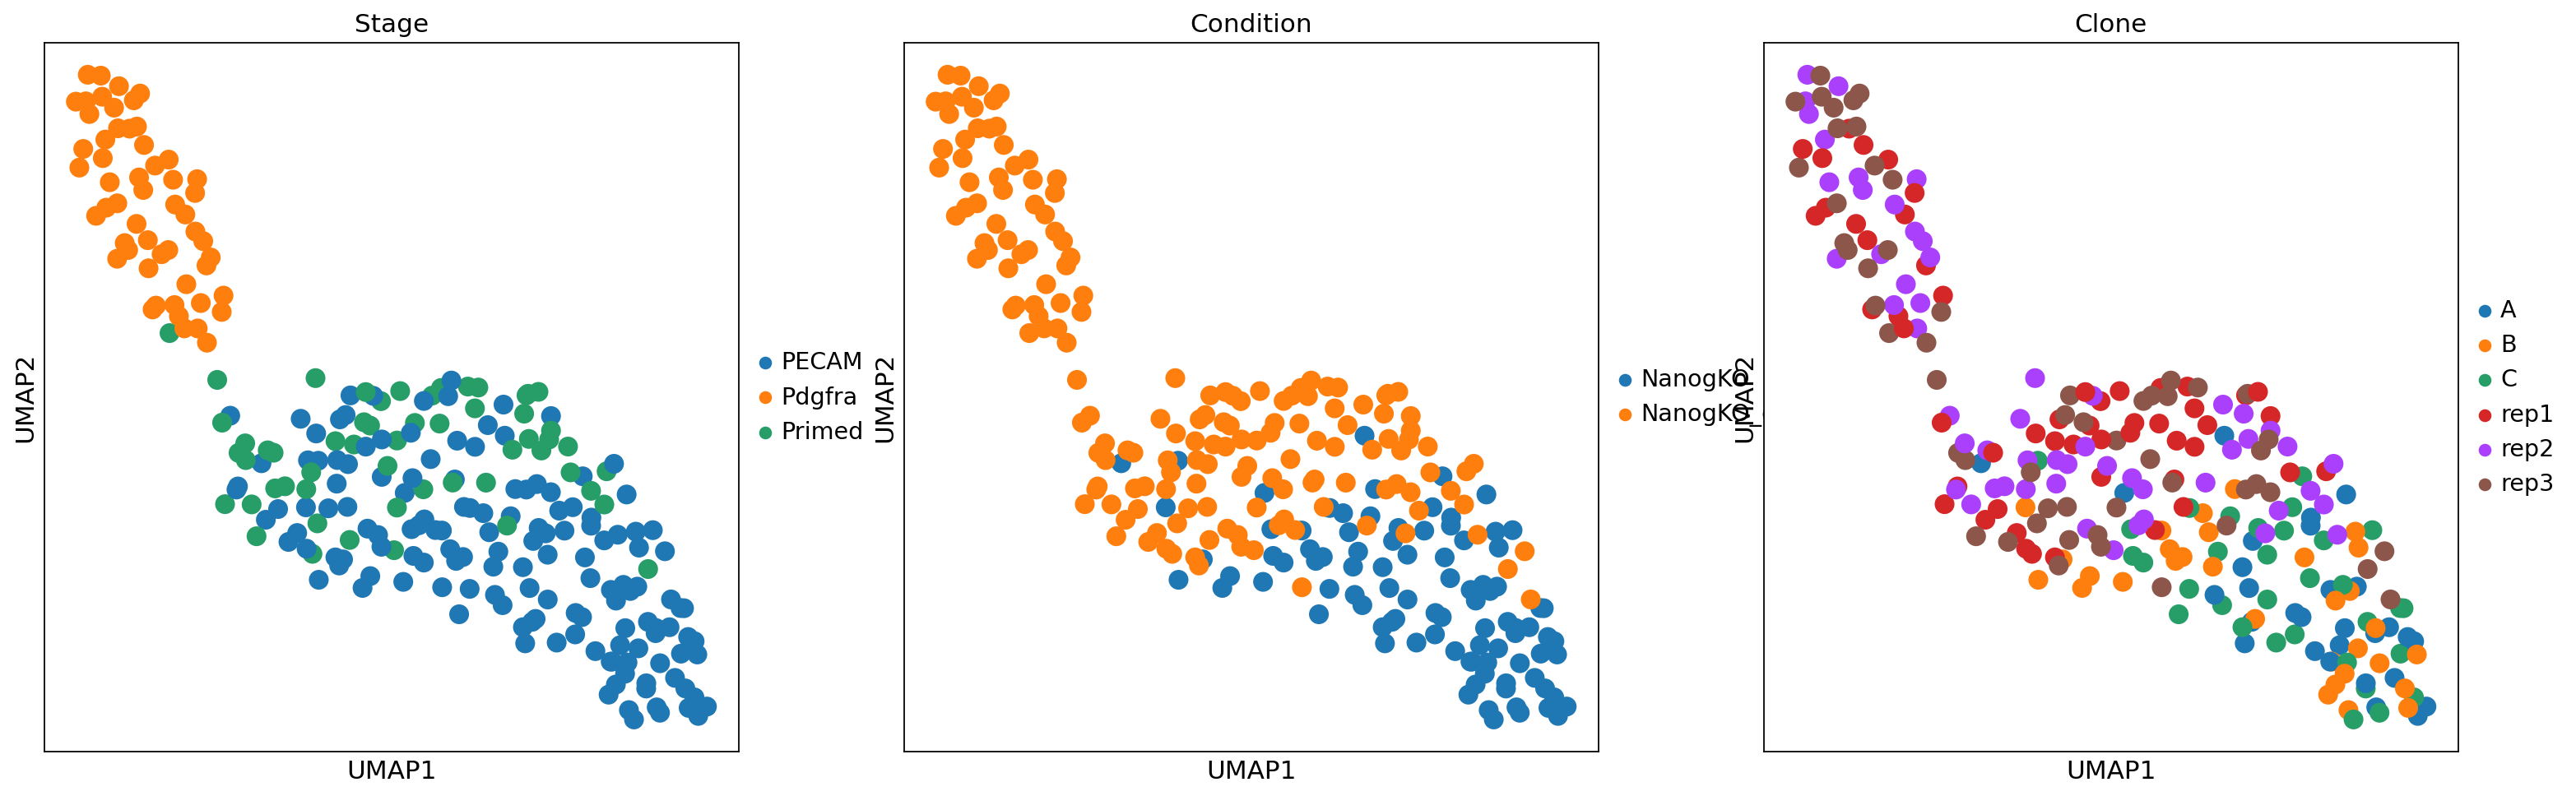

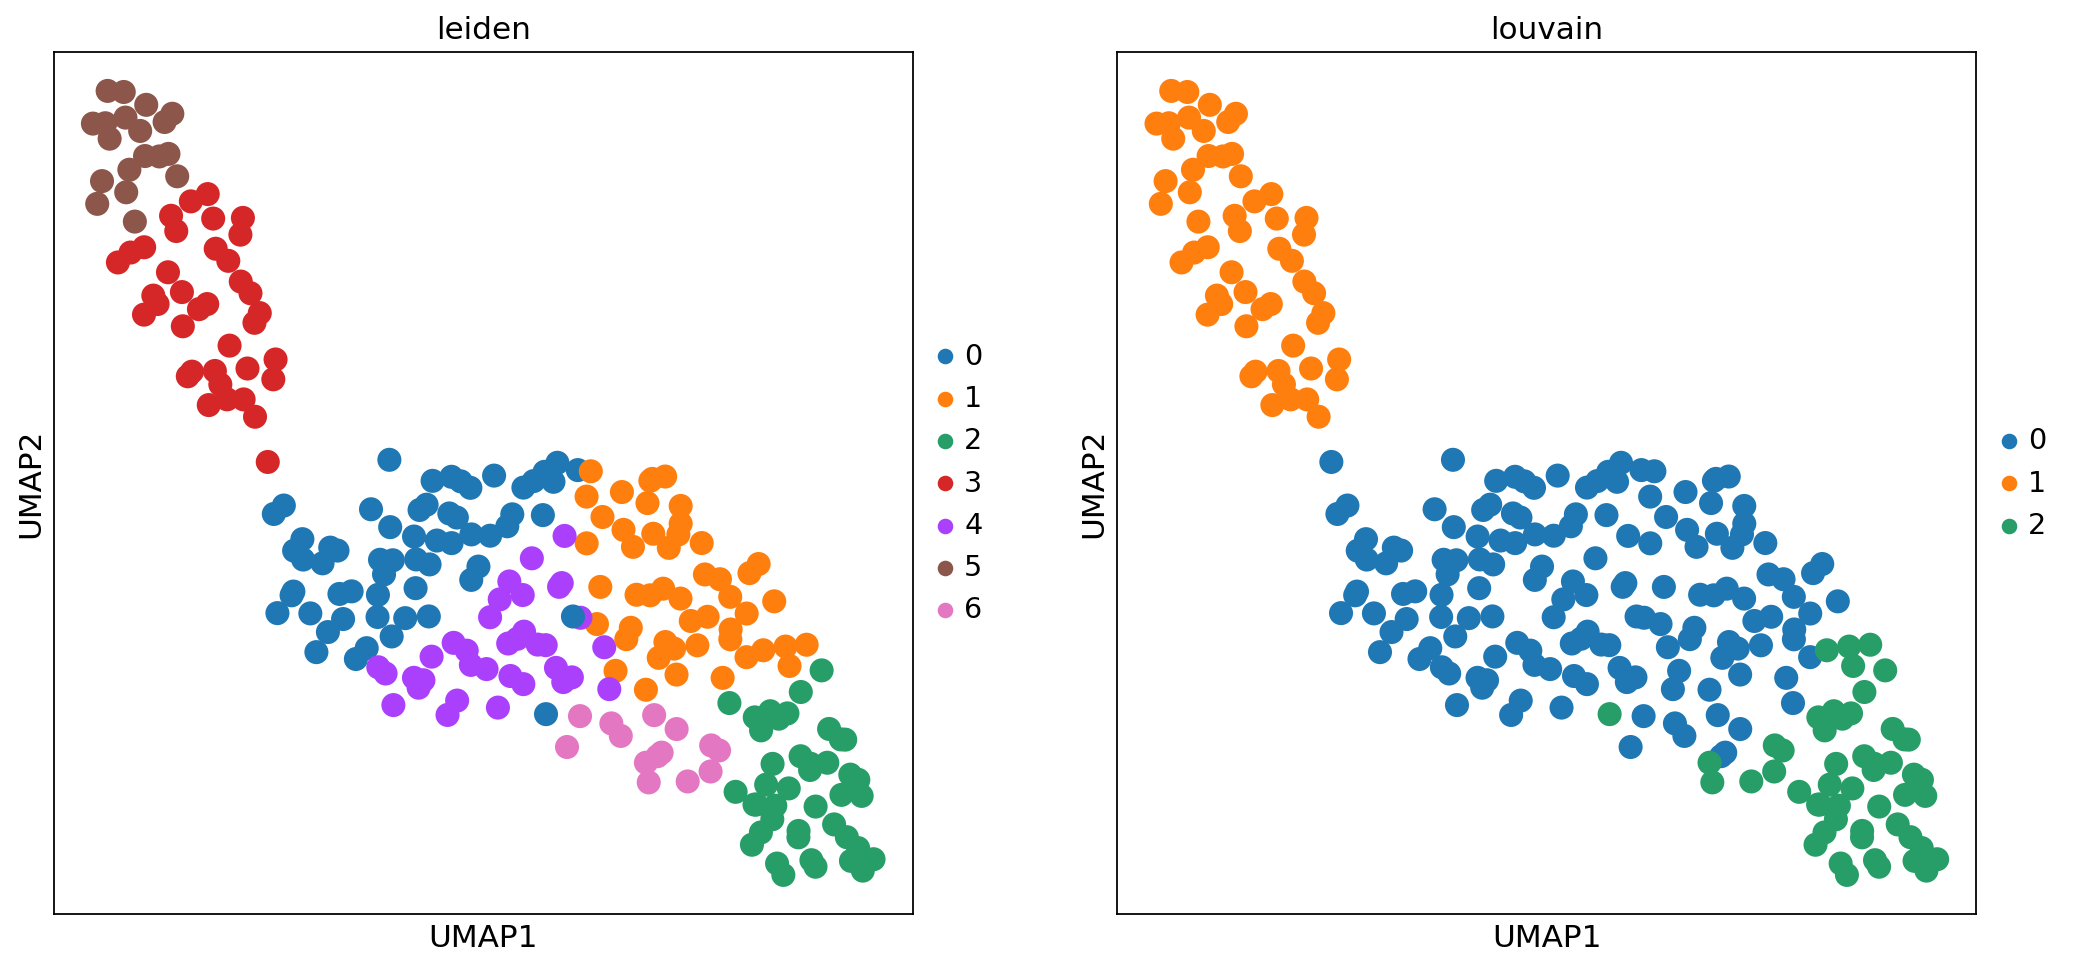

In [19]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata, color=['Stage', 'Condition', 'Clone'])
sc.pl.umap(adata, color=['leiden', 'louvain'])

In [37]:
#find markers:
adata.obs.louvain.cat.categories

sc.tl.rank_genes_groups(adata, groupby="louvain", method="wilcoxon")
dedf = sc.get.rank_genes_groups_df(adata, group="0", log2fc_min = 0.5, pval_cutoff=0.05)
dedf.to_csv('20220217_44JMARS_lou0_ESCresc_UP.csv')
print(dedf)
dedf = sc.get.rank_genes_groups_df(adata, group="1", log2fc_min = 0.5, pval_cutoff=0.05)
dedf.to_csv('20220217_44JMARS_lou1_PrE_UP.csv')
print(dedf)
dedf = sc.get.rank_genes_groups_df(adata, group="2", log2fc_min = 0.5, pval_cutoff=0.05)
dedf.to_csv('20220217_44JMARS_lou2_Ndelta_UP.csv')
print(dedftheme_bw)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
       names    scores  logfoldchanges         pvals     pvals_adj
0    Chchd10  6.307183        1.159885  2.841592e-10  7.526809e-07
1       Ldhb  5.708210        1.406337  1.141701e-08  1.374608e-05
2      Nedd4  5.437817        1.265115  5.393729e-08  3.571728e-05
3      Gsta4  5.110949        1.325234  3.205443e-07  1.463893e-04
4     Slc2a1  5.026237        1.309774  5.001970e-07  1.892745e-04
5        Mt2  4.994577        1.475579  5.896478e-07  2.055078e-04
6      L1td1  4.753277        0.686242  2.001460e-06  4.908767e-04
7      Zfp42  4.528234        0.998676  5.947864e-06  1.312892e-03
8      Peg10 

In [21]:
adata.obs['Stage_Condition'] = adata.obs.Stage.astype(str) + "-" + adata.obs.Condition.astype(str)
adata.obs['Stage_Condition'] = adata.obs['Time_CellType'].astype('category')

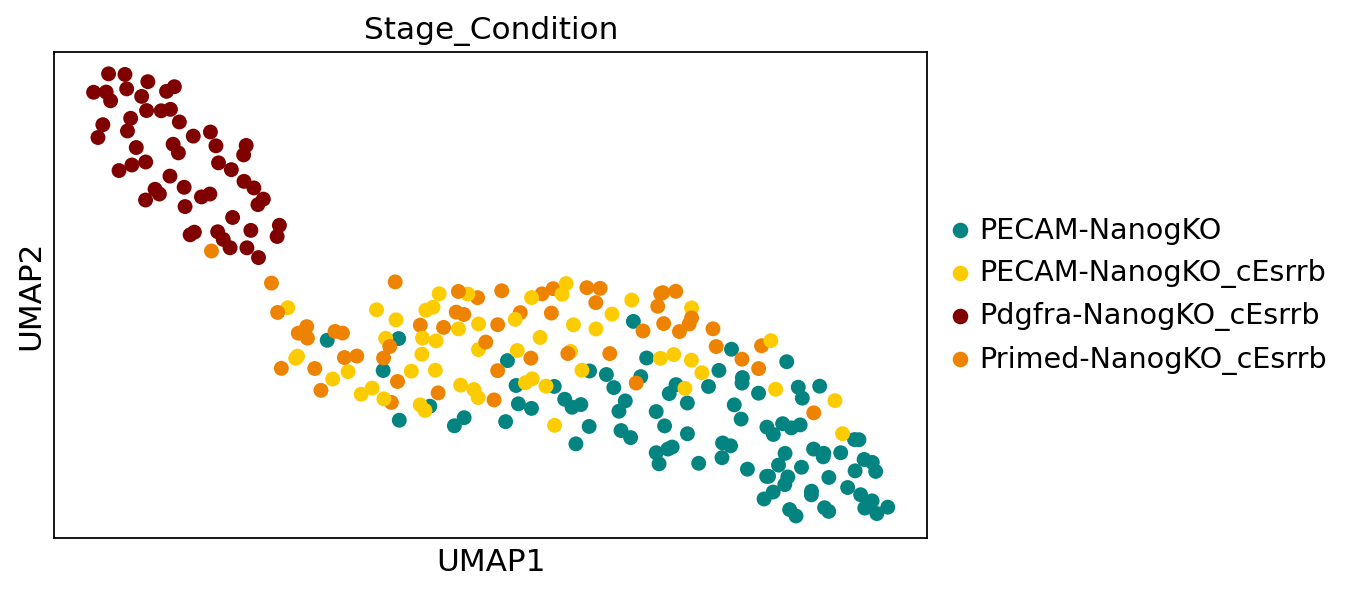

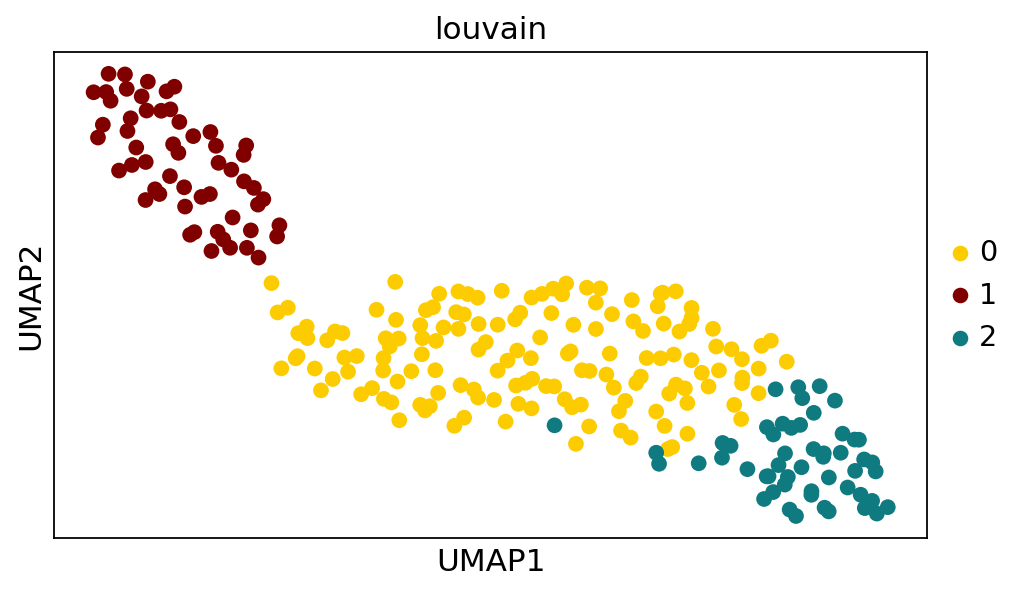

In [22]:
adata.uns['Stage_Condition_colors'] = ['#038480','#FCCC00','#800000', '#ED8300']
adata.uns['louvain_colors'] = ['#FCCC00','#800000','#0f7b80']

#adata.uns['Timepoint_colors'] = ['#125c46','#876a08']
#adata.uns['Time_CellType_colors'] = ['#264663','#0c3140','#876a08','#873f08','#800000','#7c8210','#567a17']

rcParams['figure.figsize'] = 7, 4
sc.pl.umap(adata, color=['Stage_Condition'], size = 180, save = 'UMAP_44J.svg')
sc.pl.umap(adata, color=['louvain'], size = 200, save = 'UMAP_44J_louvain.svg')

In [23]:
#Save adata for pySCENIC/ Velocity etc:
adata.write("../data/processed/20220217_TK_adata.h5ad")

In [34]:
adata = sc.read("../data/processed/20220217_TK_adata.h5ad")

In [35]:
adata

AnnData object with n_obs × n_vars = 256 × 13244
    obs: 'Well_ID', 'Well_coordinates', 'plate_ID', 'Subject_ID', 'Amp_batch_ID', 'Cell_barcode', 'Pool_barcode', 'Batch', 'Condition', 'SampleName', 'Stage', 'Stage_FACS', 'Source', 'SubGroup', 'Group', 'Clone', 'UFD', 'FACS_index', 'n_genes_by_counts', 'total_counts', 'total_counts_percent.mito', 'pct_counts_percent.mito', 'total_counts_percent.ercc', 'pct_counts_percent.ercc', 'total_counts_percent.ribo', 'pct_counts_percent.ribo', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'n_counts', 'louvain', 'leiden', 'Stage_Condition'
    var: 'percent.mito', 'percent.ercc', 'percent.ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Clo

### Percent contribution:

In [55]:
df = adata.obs.groupby(['Stage_Condition', 'louvain']).count()['Stage'].unstack()
df = df / adata.obs.groupby('louvain').count()['Stage'].values 
df *= 100

In [56]:
#adata.obs.groupby(['Stage_Condition', 'louvain']).count()['Stage'].unstack

<bound method Series.unstack of Stage_Condition        louvain
PECAM-NanogKO          0          45
                       1           0
                       2          47
PECAM-NanogKO_cEsrrb   0          50
                       1           0
                       2           4
Pdgfra-NanogKO_cEsrrb  0           0
                       1          54
                       2           0
Primed-NanogKO_cEsrrb  0          54
                       1           1
                       2           1
Name: Stage, dtype: int64>

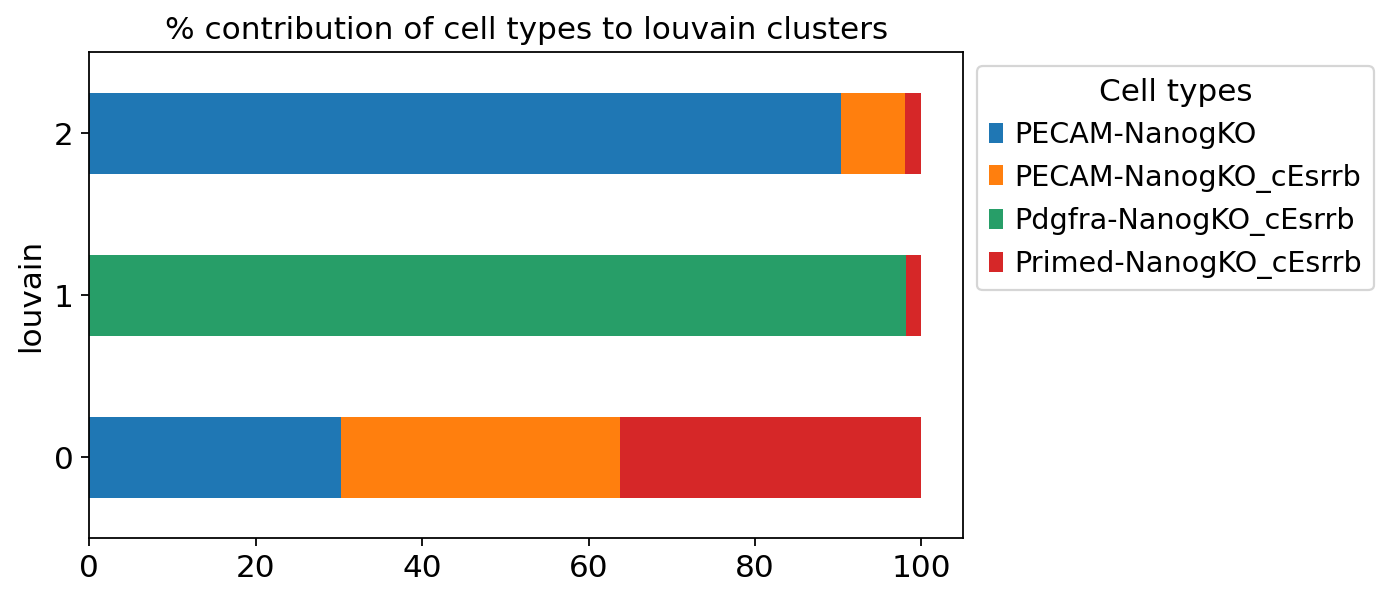

In [63]:
df.T.plot.barh(stacked=True, title="% contribution of cell types to louvain clusters", figsize=[10, 4])
plt.legend(loc="upper left", bbox_to_anchor=(1,1), title='Cell types')
plt.grid(visible=None)
plt.savefig('clustercontributions_44J_louvain.svg')
#print(df)

In [ ]:
df = adata.obs.groupby(['leiden_ecm', 'leiden']).count()['Stage'].unstack()
df = df / adata.obs.groupby('leiden').count()['Stage'].values 
df *= 100

In [4]:
adata.var['percent.mito']

0610009B22Rik    False
0610009L18Rik    False
0610010F05Rik    False
0610012G03Rik    False
0610030E20Rik    False
                 ...  
mt-Rnr1           True
mt-Rnr2           True
mt-Tl1            True
mt-Tp             True
mt-Tt             True
Name: percent.mito, Length: 13244, dtype: bool

# Velocity

In [5]:
import scvelo as scv
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization


In [6]:
scv.utils.show_proportions(adata)

Abundance of ['spliced', 'unspliced']: [0.96 0.04]


In [13]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)


Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [14]:
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/256 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


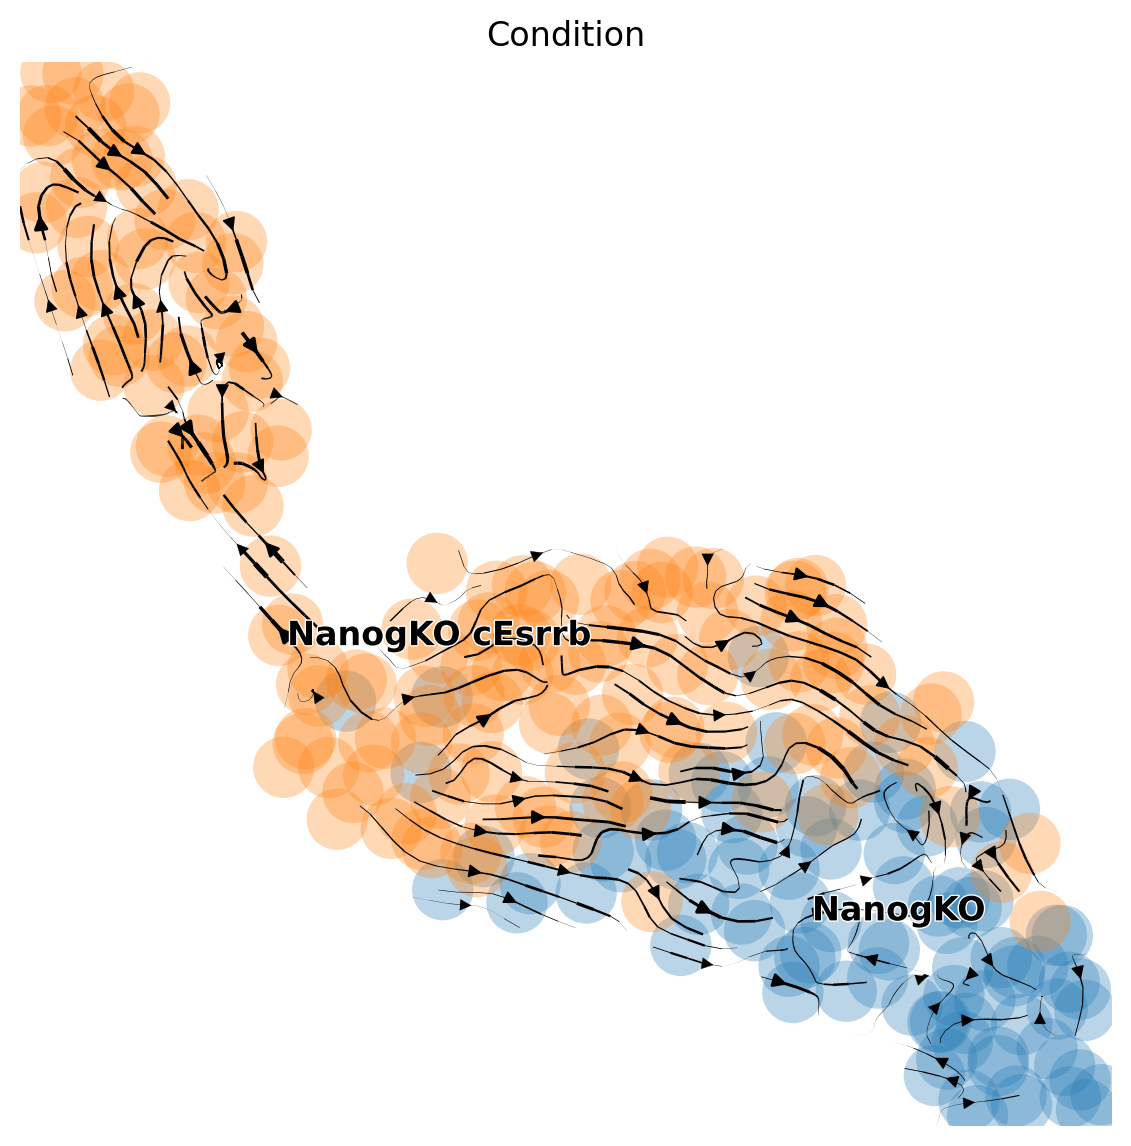

In [15]:
rcParams['figure.figsize'] = 7, 7
scv.pl.velocity_embedding_stream(adata, basis='umap', color=['Condition'])

In [16]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)
scv.tl.latent_time(adata)


recovering dynamics (using 1/12 cores)
    finished (0:00:00) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/256 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


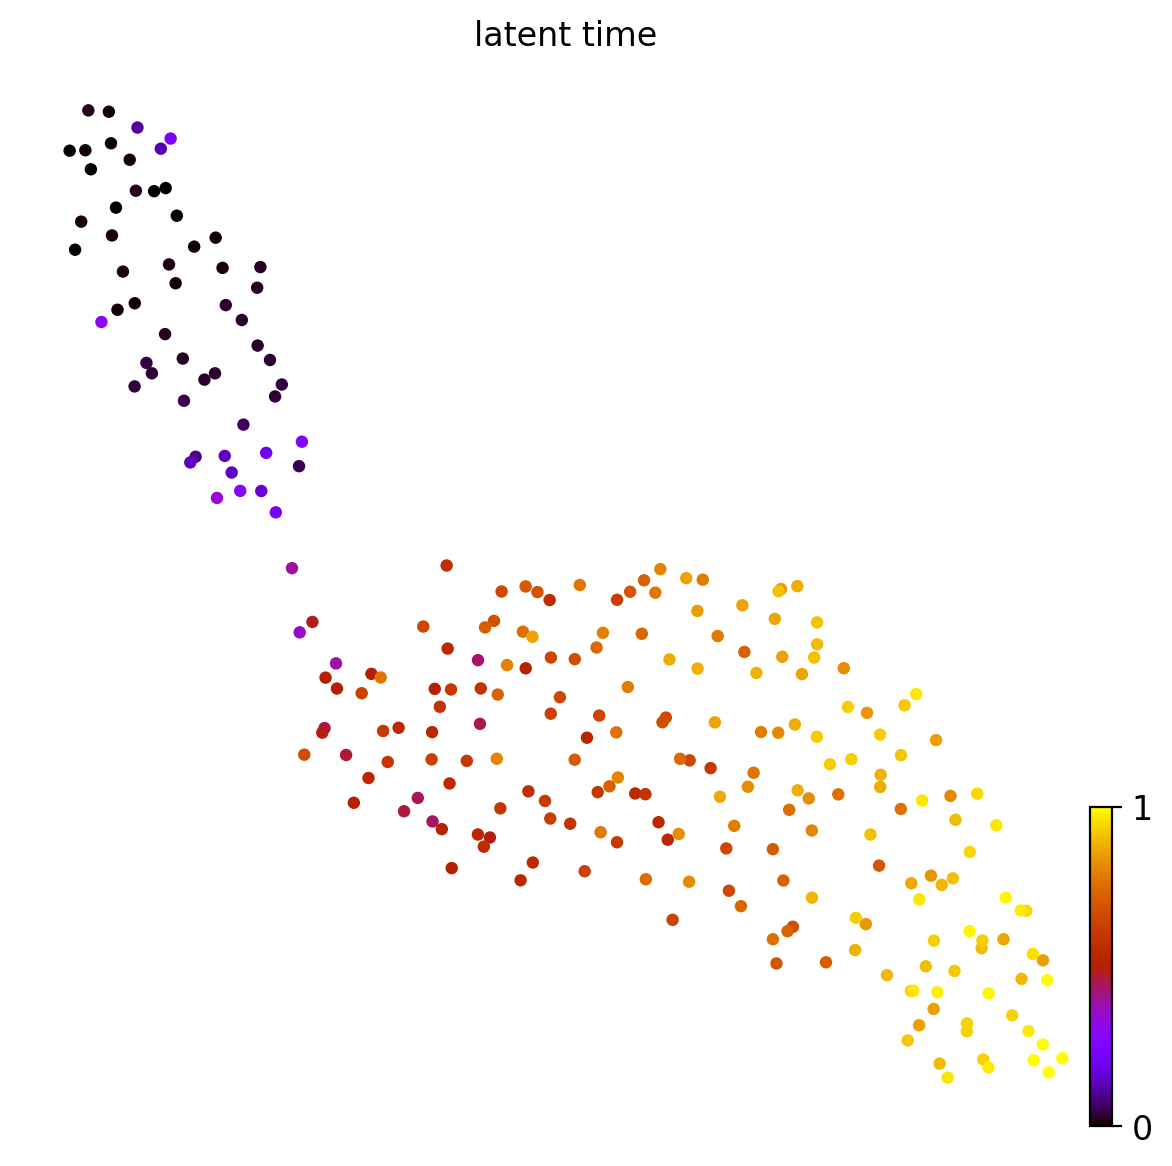

In [17]:
rcParams['figure.figsize'] = 7, 7
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80, colorbar=True)
#scv.pl.scatter(adata, color='pseudotime', color_map='gnuplot', size=80, colorbar=True)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


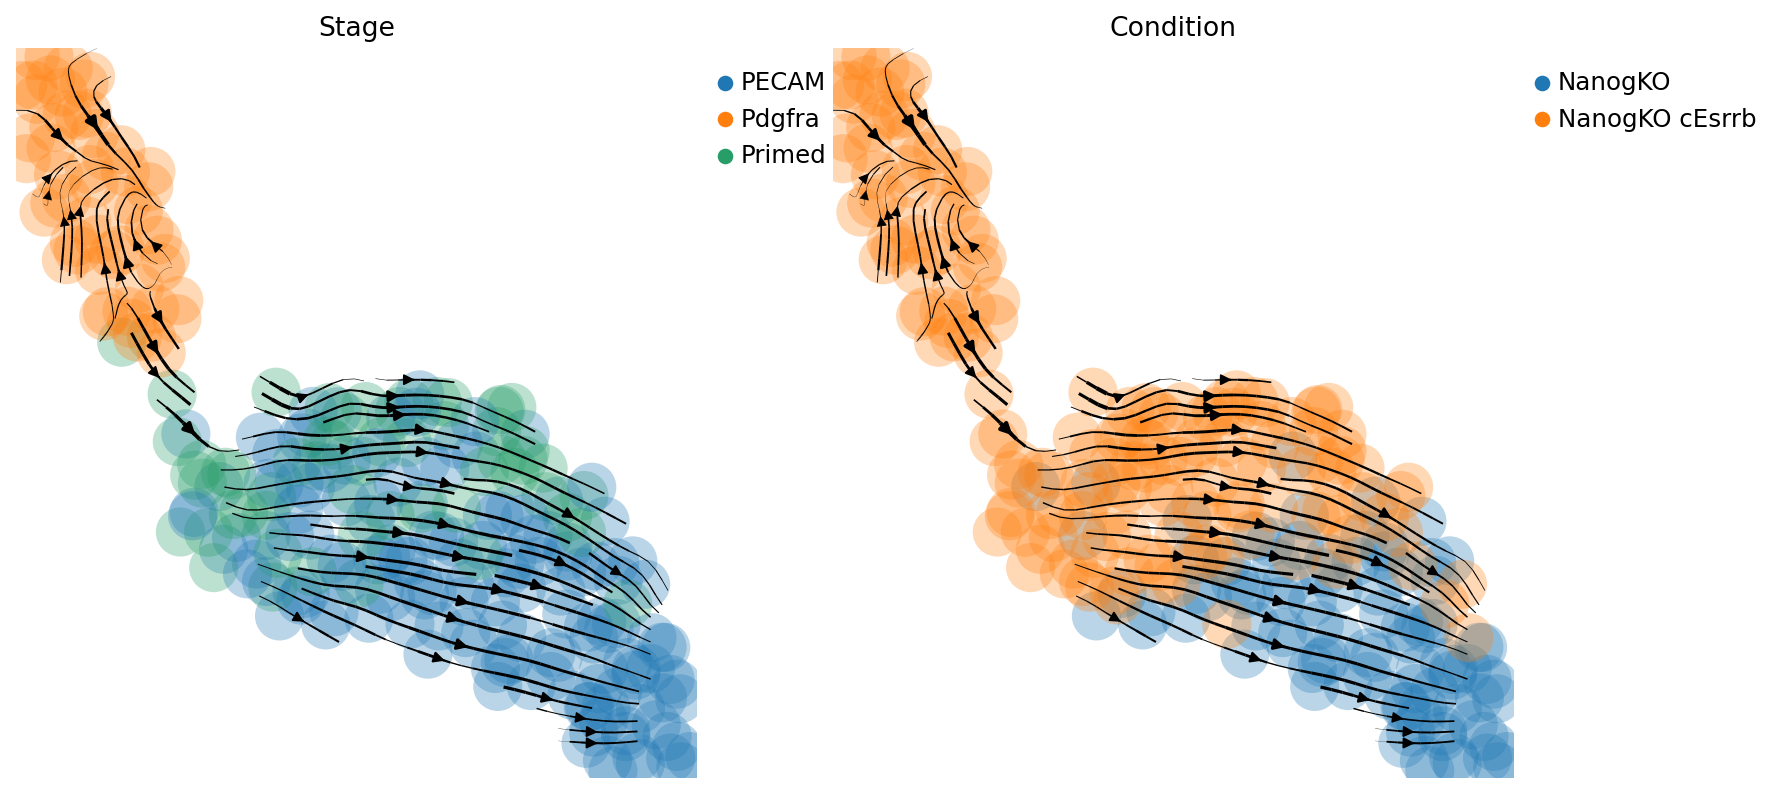

In [18]:
scv.pl.velocity_embedding_stream(adata, basis='umap', smooth=.8, min_mass=4, color=['Stage', 'Condition'], legend_loc = "upper right")

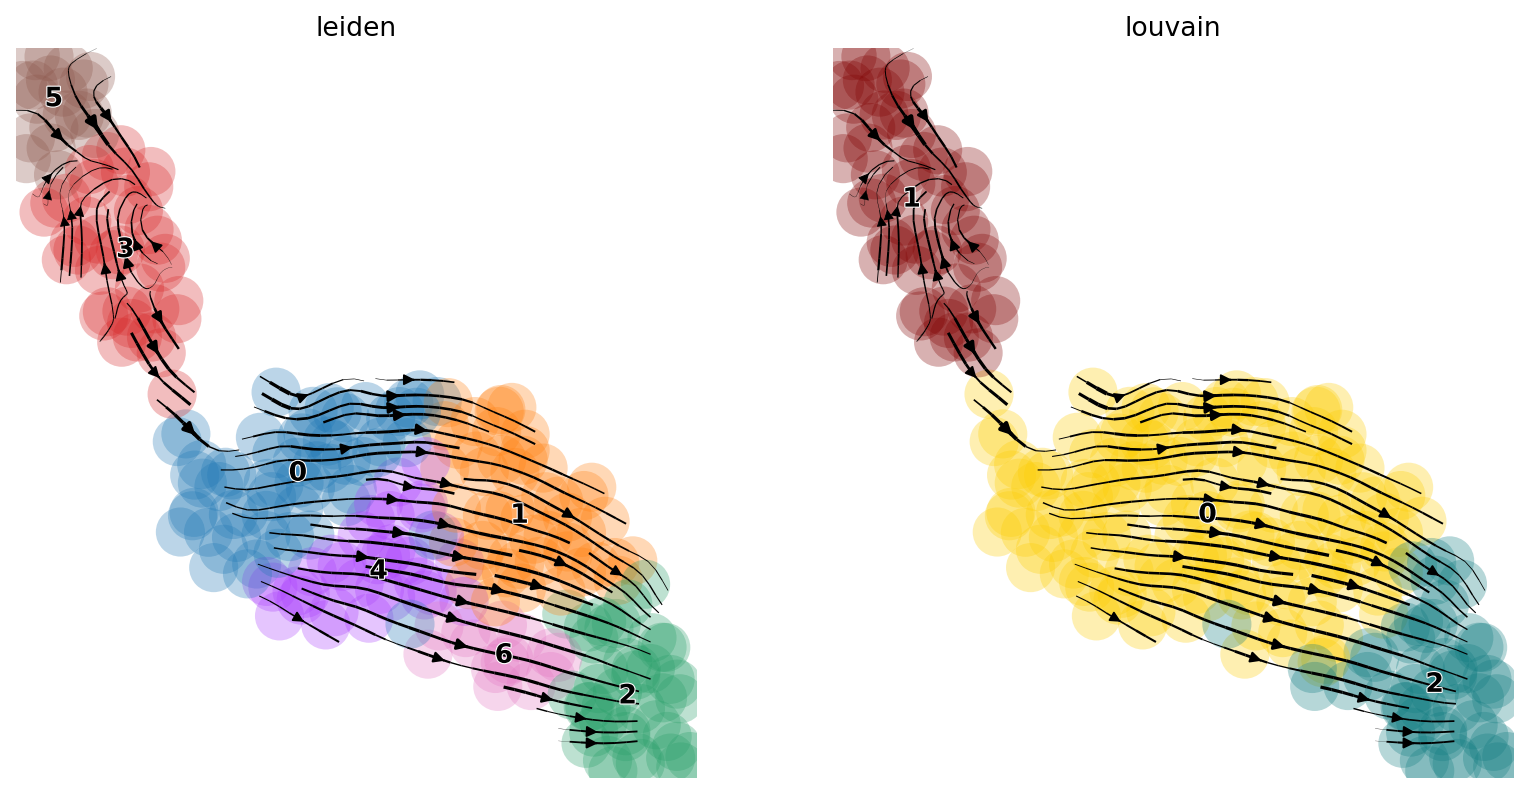

In [19]:
scv.pl.velocity_embedding_stream(adata, basis='umap', smooth=.8, min_mass=4, color=['leiden', 'louvain'])